In [1]:
'''
Test diff methods to calc class 99 prob
'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

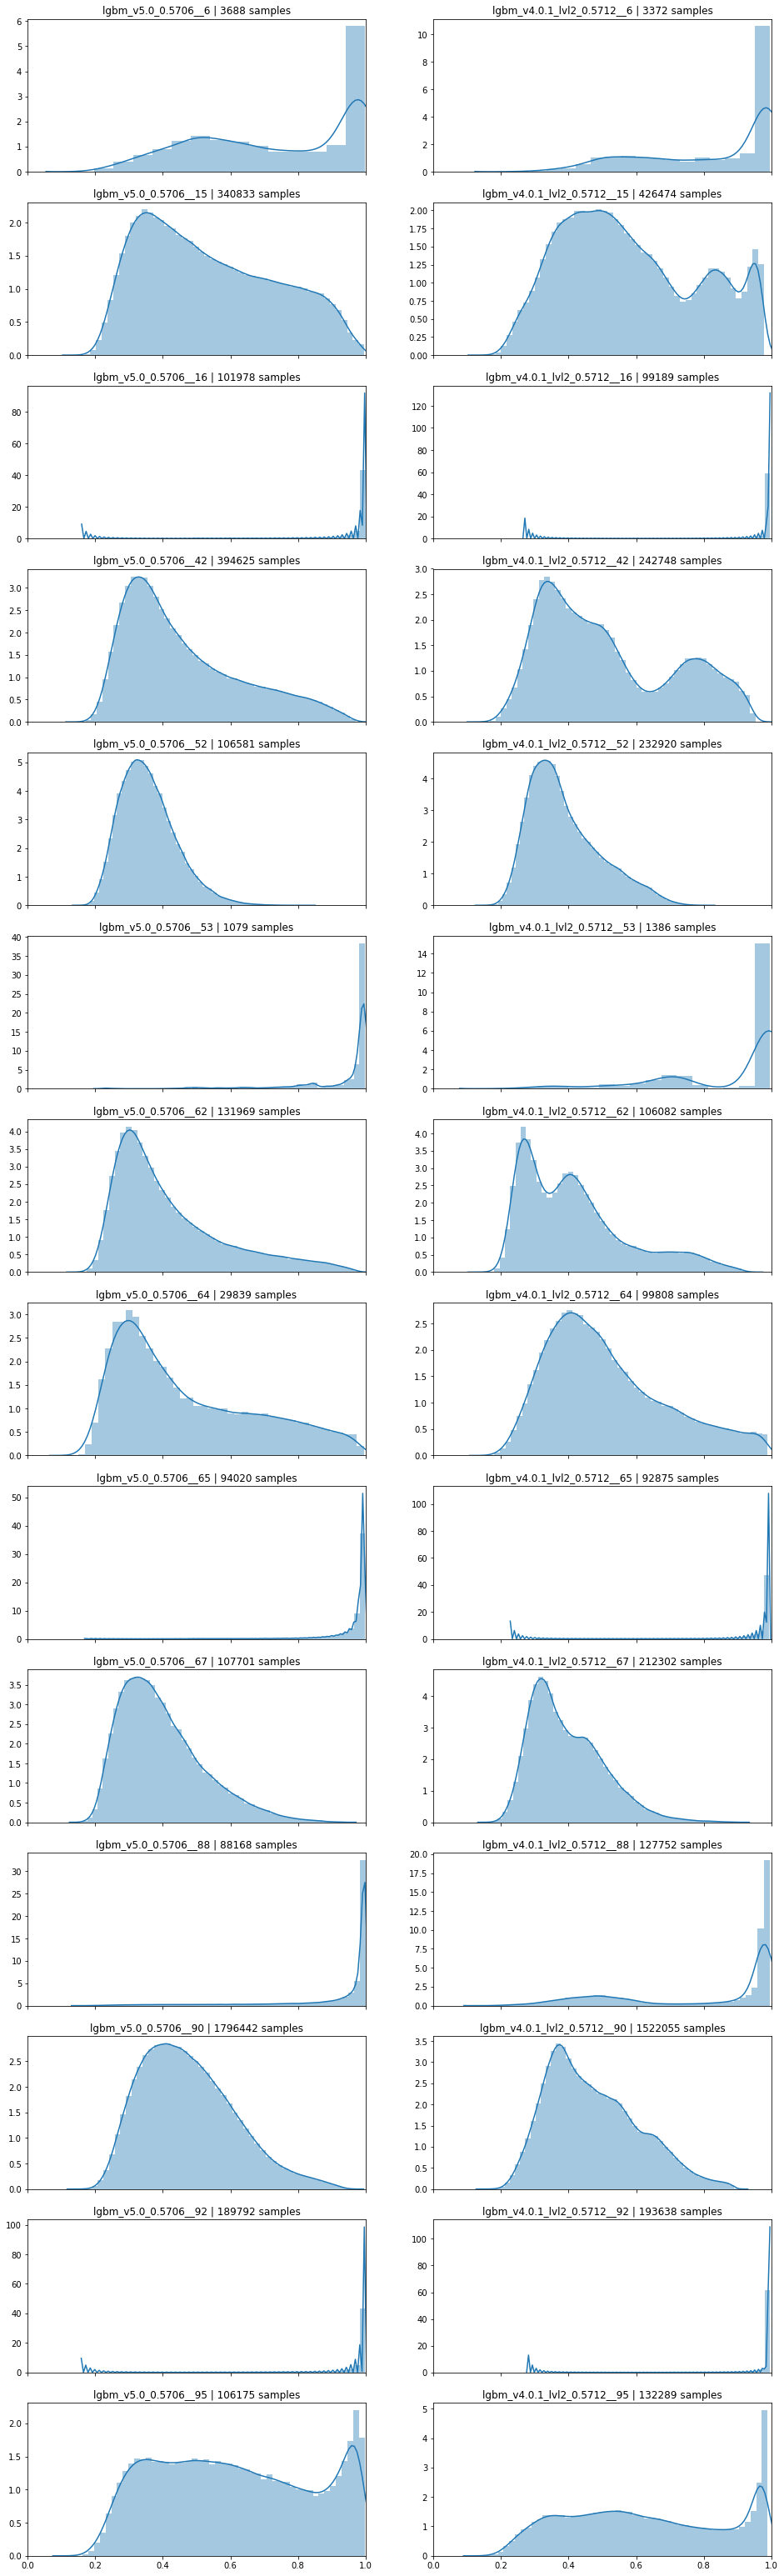

In [85]:
preds = [
    pd.read_hdf('../level_1_preds/lgbm_v5.0_0.5706_test.h5'),
    pd.read_hdf('../level_2_preds/lgbm_v4.0.1_lvl2_0.5712_test.h5'),
]

f,axes = plt.subplots(14, 2, figsize=(16, 14 * 4), sharex=True)

for j, pred in enumerate(preds):
    for i, col in enumerate(list(pred.columns)[1:]): 
        narr = pred.iloc[:,1:].values
        amax = np.argmax(narr, axis=1) == i
        narr = narr[amax, i]
        nsamps = len(narr)
        
        sns.distplot(narr, ax=axes[i, j])
        axes[i, j].set_title(f'{col} | {nsamps} samples')
        axes[i,j].set_xlim(0,1)
f.savefig('../edas/preds_compare_peaks15mean.png')

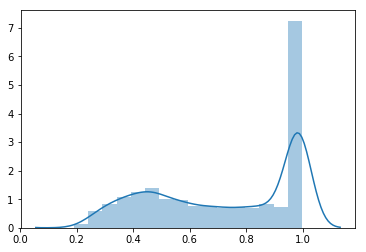

In [13]:
preds_lvl2 = pd.read_hdf('../level_2_preds/lgbm_v4.1_lvl2_0.5719_oof.h5')
narr2 = preds_lvl2.iloc[:,1:].values
sns.distplot(np.max(narr2, axis=1))

In [80]:
'''
Experimental 99 dilation
'''
def save_modded_sub(y_test, sub_name, rs_bins):

    # Get submission header
    col_names = list(pd.read_csv(filepath_or_buffer='../data/sample_submission.csv').columns)
    num_classes = len(col_names) - 1

    # Get test ids
    object_ids = pd.read_csv(filepath_or_buffer='../data/test_set_metadata.csv', usecols=['object_id']).values.astype(int)
    num_ids = object_ids.size

    # Class 99 adjustment - remember these are conditional probs on redshift
    c99_bin0_prob = 0.02
    c99_bin1_9_prob = 0.11

    c99_probs = np.zeros((y_test.shape[0],1))
    c99_probs[rs_bins==0] = c99_bin0_prob
    c99_probs[rs_bins!=0] = c99_bin1_9_prob
    
    # Dilation function
    dilation = lambda maxp : 0.26/np.pi * np.arccos((2 * (maxp - 0.25))**1) - 0.13
    
    y_test[rs_bins==0] *= (1 - c99_bin0_prob)
    naive_99_eg = np.ones(np.sum(rs_bins!=0)) * c99_bin1_9_prob
    max_eg = np.max(y_test[rs_bins!=0], axis=1)
    final_c99_bin1_9_prob = naive_99_eg + dilation(max_eg)
    c99_probs[rs_bins!=0] = final_c99_bin1_9_prob[:,None]
    
    y_test[rs_bins!=0] *= (1 - final_c99_bin1_9_prob[:,None])

    sub = np.hstack([object_ids, y_test, c99_probs])

    h = ''
    for s in col_names:
        h += s + ','
    h = h[:-1]

    # Write to file
    np.savetxt(
        fname=sub_name,
        X=sub,
        fmt=['%d'] + ['%.6f'] * num_classes,
        delimiter=',',
        header=h,
        comments='',
    )

In [36]:
raw_sub = pd.read_csv('../subs/lgbm_v4.0.1_lvl2_0.5712_3_99.csv')
rs_bins = np.load('../data/rs_bins.npy')

In [37]:
raw_sub.head()

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000724,0.004769,0.000749,0.535975,0.218332,0.000614,0.035208,0.000797,0.000707,0.006288,0.000902,0.049012,0.000630,0.005293,0.14
1,14,0.000886,0.029676,0.000856,0.174132,0.102041,0.000805,0.024875,0.001642,0.000833,0.010931,0.002548,0.505962,0.000820,0.003992,0.14
2,17,0.000751,0.017683,0.000708,0.077980,0.054714,0.000682,0.022836,0.002093,0.000713,0.014528,0.013859,0.610340,0.000694,0.042419,0.14
3,23,0.000706,0.007887,0.000716,0.060213,0.064567,0.000597,0.053199,0.003325,0.001001,0.329386,0.000839,0.333252,0.000625,0.003686,0.14
4,34,0.000858,0.007999,0.000869,0.053889,0.095041,0.000724,0.009587,0.001609,0.001133,0.009219,0.001005,0.674036,0.000736,0.003294,0.14


In [41]:
# reverse engineer 99
subsub = raw_sub.iloc[:,1:-1].values
rev_sub = subsub * 1 / (1 - raw_sub.iloc[:,[-1]].values)
rev_sub[:5,:]

array([[8.41860465e-04, 5.54534884e-03, 8.70930233e-04, 6.23226744e-01,
        2.53874419e-01, 7.13953488e-04, 4.09395349e-02, 9.26744186e-04,
        8.22093023e-04, 7.31162791e-03, 1.04883721e-03, 5.69906977e-02,
        7.32558140e-04, 6.15465116e-03],
       [1.03023256e-03, 3.45069767e-02, 9.95348837e-04, 2.02479070e-01,
        1.18652326e-01, 9.36046512e-04, 2.89244186e-02, 1.90930233e-03,
        9.68604651e-04, 1.27104651e-02, 2.96279070e-03, 5.88327907e-01,
        9.53488372e-04, 4.64186047e-03],
       [8.73255814e-04, 2.05616279e-02, 8.23255814e-04, 9.06744186e-02,
        6.36209302e-02, 7.93023256e-04, 2.65534884e-02, 2.43372093e-03,
        8.29069767e-04, 1.68930233e-02, 1.61151163e-02, 7.09697674e-01,
        8.06976744e-04, 4.93244186e-02],
       [8.20930233e-04, 9.17093023e-03, 8.32558140e-04, 7.00151163e-02,
        7.50779070e-02, 6.94186047e-04, 6.18593023e-02, 3.86627907e-03,
        1.16395349e-03, 3.83006977e-01, 9.75581395e-04, 3.87502326e-01,
        7.267

In [81]:
save_modded_sub(rev_sub, '../subs/experimental_mod_3.csv', rs_bins)
msu = pd.read_csv('../subs/experimental_mod_3.csv')

(0.13, 0.19)

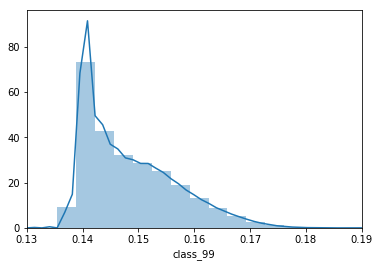

In [61]:
sns.distplot(msu.iloc[:,-1])
plt.xlim(0.13,0.19)

(0.01, 0.27)

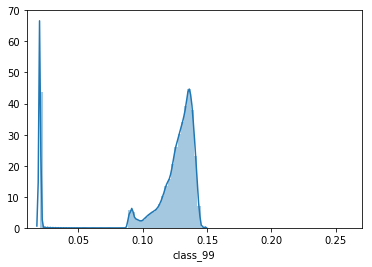

In [82]:
sns.distplot(msu.iloc[:,-1])
plt.xlim(0.01,0.27)